# Comparison of real single-node HPL executions on Dahu

In [1]:
import io
import zipfile
import pandas
import yaml
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    result = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    result['index'] = range(len(result))
    info = get_yaml(archive_name, 'info.yaml')
    hostname = [k for k in info if k.endswith('grid5000.fr')]
    assert len(hostname) == 1
    hostname = hostname[0][:-21]
    result['hostname'] = hostname
    result['jobid'] = info['jobid']
    result['filename'] = archive_name
    return result

def read_result(name):
    result = read_csv(name, 'results.csv')
    temperatures = read_csv(name, 'temperatures.csv')
    matrix_size = result['matrix_size'].unique()
    assert len(matrix_size) == 1
    temperatures['matrix_size'] = matrix_size[0]
    result['start_timestamp'] = pandas.to_datetime(result['start_timestamp'])
    result['stop_timestamp'] = pandas.to_datetime(result['stop_timestamp'])
    temperatures['timestamp'] = pandas.to_datetime(temperatures['timestamp'])
    first_time = min(result.start_timestamp.min(), temperatures.timestamp.min())
    result['start_timestamp'] -= first_time
    result['stop_timestamp'] -= first_time
    temperatures['timestamp'] -= first_time
    return result, temperatures

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

directory = 'performance_evolution/'
exp_files = [directory + filename for filename in os.listdir(directory)]
results = [read_result(filename) for filename in exp_files]

df = pandas.concat([t[0] for t in results])
temperatures = pandas.concat([t[1] for t in results])
df.head()

,bcast,block_size,depth,filename,gflops,hostname,index,jobid,matrix_size,mem_align,...,proc_p,proc_q,process_per_node,residual,rfact,start_timestamp,stop_timestamp,swap,thread_per_process,time
0,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,845.3,dahu-3,0,1856201,65536,8,...,4,8,32,0.001254,2,00:01:24.663831,00:05:15.980332,0,1,222.00
1,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,832.8,dahu-3,1,1856201,65536,8,...,4,8,32,0.001254,2,00:05:16.115881,00:09:10.388544,0,1,225.32
2,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,823.6,dahu-3,2,1856201,65536,8,...,4,8,32,0.001254,2,00:09:10.487829,00:13:07.634939,0,1,227.85
3,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,830.0,dahu-3,3,1856201,65536,8,...,4,8,32,0.001254,2,00:13:07.746605,00:17:03.155056,0,1,226.09
4,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,830.1,dahu-3,4,1856201,65536,8,...,4,8,32,0.001254,2,00:17:03.259762,00:20:58.566731,0,1,226.07


### Checking the parameters

In [2]:
name_exceptions = {'time', 'gflops', 'residual', 'mode', 'index', 'start_timestamp', 'stop_timestamp', 'jobid', 'filename', 'hostname'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,proc_q,block_size,thread_per_process,depth,matrix_size,swap,bcast,pfact,mem_align,rfact,process_per_node,proc_p
0,8,128,1,1,65536,0,2,1,8,2,32,4
0,8,128,1,1,32768,0,2,1,8,2,32,4


In [3]:
all_versions = {v: [] for v in ['gcc', 'mpi', 'kernel', 'version', 'cpu']}
for filename in exp_files:
    info = get_yaml(filename, 'info.yaml')
    host = [key for key in info.keys() if key.startswith('dahu')]
    assert len(host) == 1
    host = host[0]
    for version in all_versions:
        all_versions[version].append(info[host][version])

all_versions = pandas.DataFrame(all_versions).drop_duplicates()
print(all_versions.version[0])
all_versions

Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u4 (2018-08-21)


,gcc,mpi,kernel,version,cpu
0,6.3.0,mpirun (Open MPI) 2.0.2,4.9.0-8-amd64,Linux version 4.9.0-8-amd64 (debian-kernel@lis...,Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz


### Comparing the executions

For each host on dahu, I performed several experiments in independent jobs. Some experiments have been made with a matrix of size $2^{15}$, others with $2^{16}$.

In each experiment, I run N consecutive calls of HPL on the node (for the small matrix, N=40, for the large matrix, N=10). Between each execution of HPL, I also record the node temperature with this command:
```sh
cat /sys/class/thermal/thermal_zone*/temp
```

On the following plots, each job is represented by a line. Each host has several lines of the same color.

In [4]:
df.groupby(['hostname', 'matrix_size', 'jobid'])[['time']].count().head(n=20)

time
hostname matrix_size jobid        
dahu-1   32768       1856230    40
                     1856261    40
         65536       1856134    10
                     1856168    10
                     1856199    10
dahu-10  32768       1856239    40
                     1856270    40
         65536       1856143    10
                     1856177    10
                     1856208    10
dahu-11  32768       1856240    40
                     1856271    40
         65536       1856144    10
                     1856178    10
                     1856209    10
dahu-12  32768       1856241    40
                     1856272    40
         65536       1856145    10
                     1856179    10
                     1856210    10

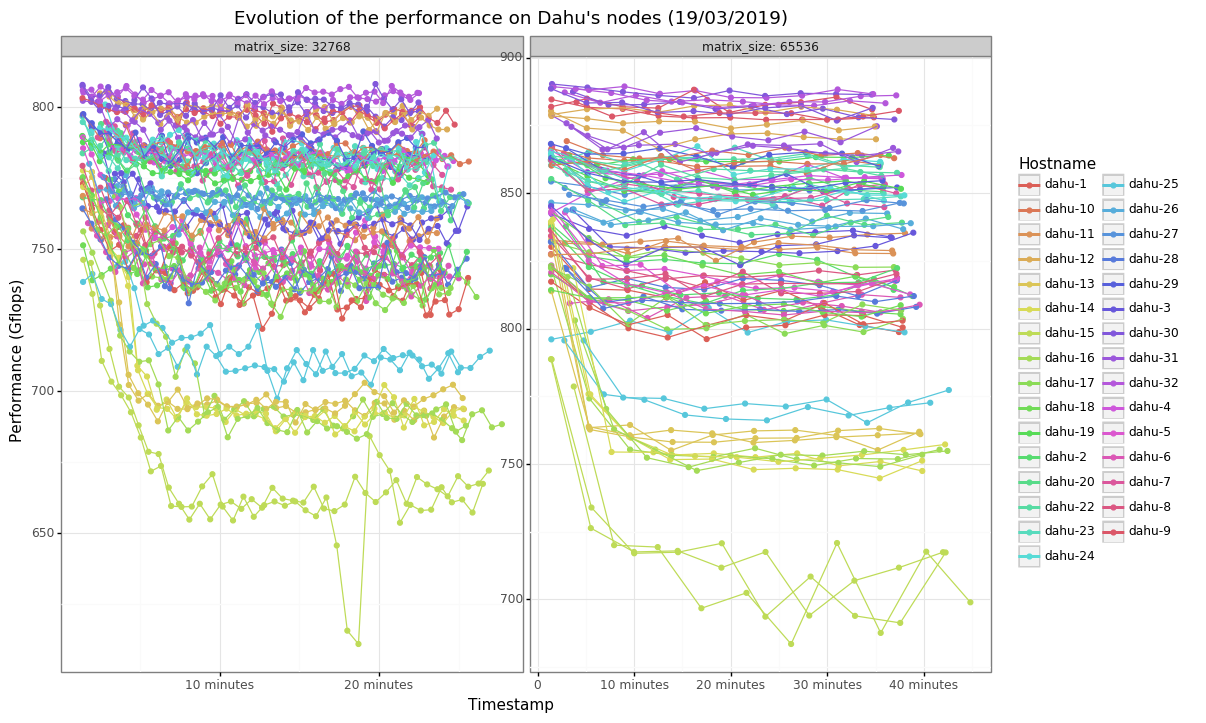

<ggplot: (-9223363310432315616)>

In [5]:
plot = ggplot(df, aes(x='start_timestamp', y='gflops', color='factor(hostname)', group='jobid')) + geom_point() + geom_line() + theme_bw() + facet_wrap('matrix_size', labeller='label_both', scales='free')
plot + xlab('Timestamp') + ylab('Performance (Gflops)') + labs(color='Hostname') + ggtitle("Evolution of the performance on Dahu's nodes (19/03/2019)")

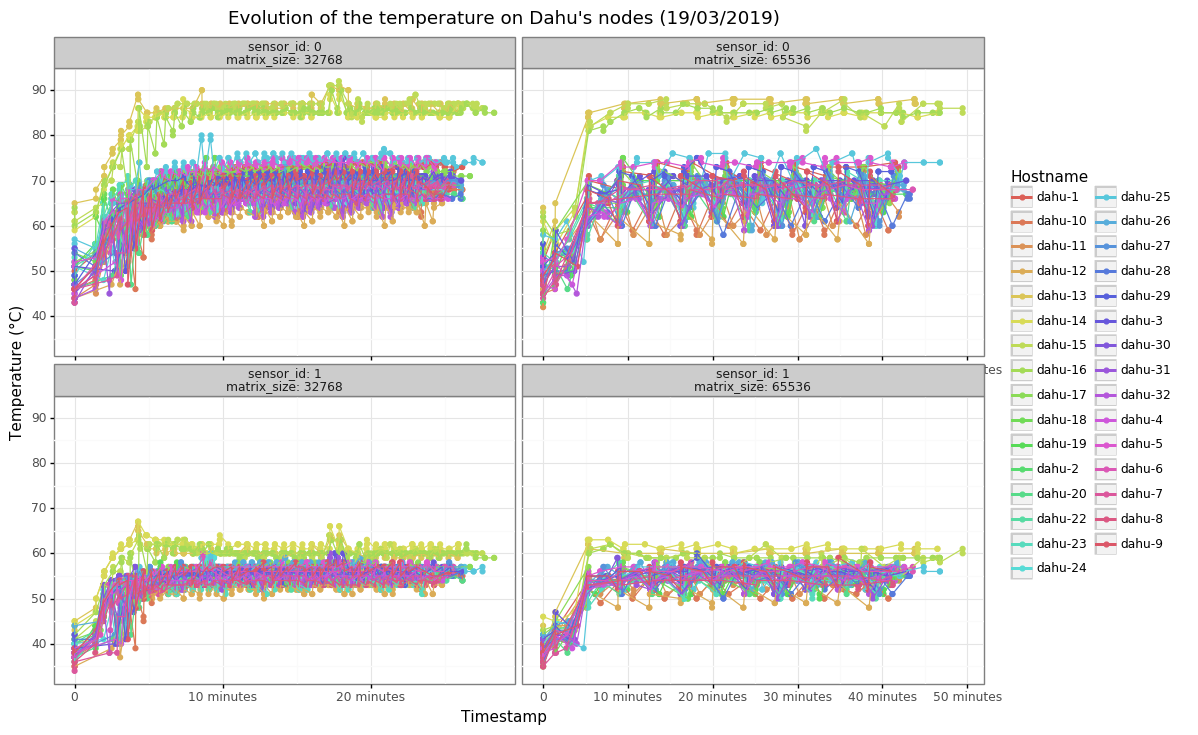

<ggplot: (8726366461199)>

In [6]:
plot = ggplot(temperatures, aes(x='timestamp', y='temperature', color='factor(hostname)')) + geom_point() + geom_line() + theme_bw() + facet_wrap(['sensor_id', 'matrix_size'], labeller='label_both', scales='free_x')
plot + xlab('Timestamp') + ylab('Temperature (°C)') + labs(color='Hostname') + ggtitle("Evolution of the temperature on Dahu's nodes (19/03/2019)")

In [7]:
problematic_hosts = list(sorted(temperatures[temperatures['temperature'] > 80].hostname.unique()))

from IPython.display import display, Markdown
display(Markdown('The problematic hosts are:\n' + '\n'.join(['- %s' % host for host in problematic_hosts])))

The problematic hosts are:
- dahu-13
- dahu-14
- dahu-15
- dahu-16

### What about older executions?

On October, I already did a similar experiment. Unfortunately, I did not collect the timestamps and the temperatures at the time and I ran only one job per host.

In [8]:
old_dir = 'heterogeneity_exp/'
old = pandas.concat([read_csv(old_dir + filename, 'results.csv') for filename in os.listdir(old_dir) if filename.endswith('.zip')])
old.head()

,bcast,block_size,depth,filename,gflops,hostname,index,jobid,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time
0,2,128,1,heterogeneity_exp/grenoble_2018-10-03_1811023.zip,793.8,dahu-1,0,1811023,65536,8,1,4,8,32,0.001254,2,0,1,236.40
1,2,128,1,heterogeneity_exp/grenoble_2018-10-03_1811023.zip,796.5,dahu-1,1,1811023,65536,8,1,4,8,32,0.001254,2,0,1,235.60
2,2,128,1,heterogeneity_exp/grenoble_2018-10-03_1811023.zip,798.4,dahu-1,2,1811023,65536,8,1,4,8,32,0.001254,2,0,1,235.05
3,2,128,1,heterogeneity_exp/grenoble_2018-10-03_1811023.zip,805.7,dahu-1,3,1811023,65536,8,1,4,8,32,0.001254,2,0,1,232.91
4,2,128,1,heterogeneity_exp/grenoble_2018-10-03_1811023.zip,810.0,dahu-1,4,1811023,65536,8,1,4,8,32,0.001254,2,0,1,231.67


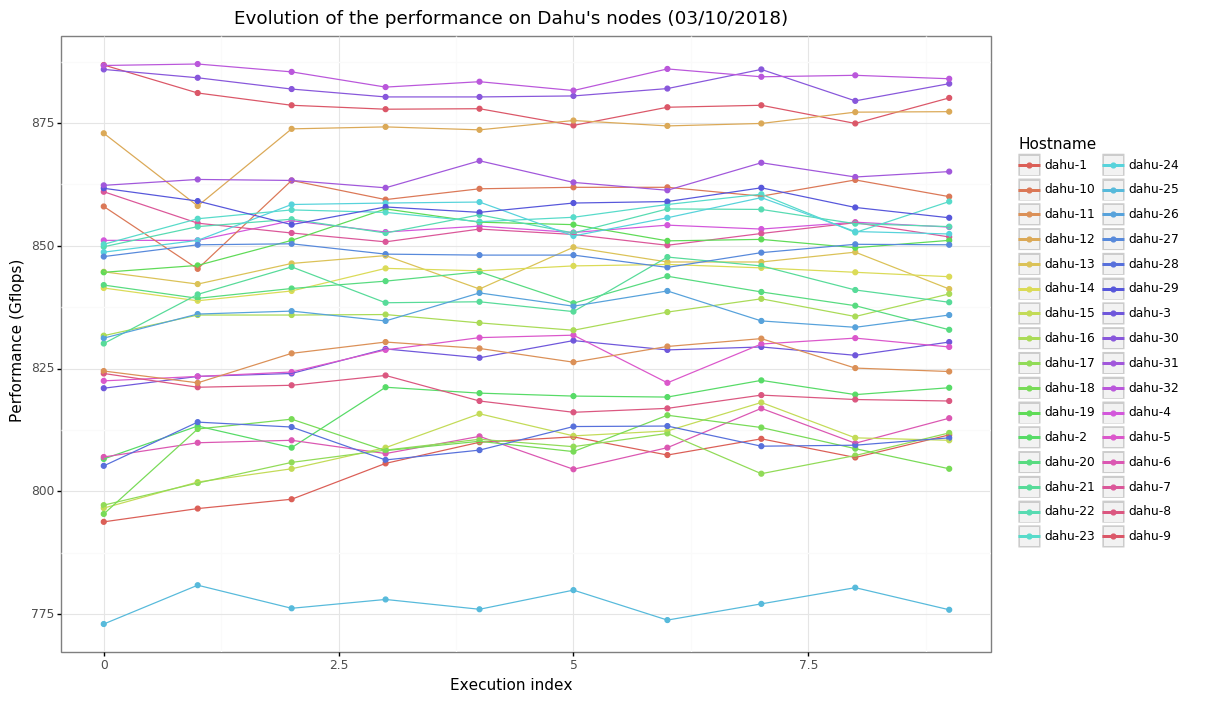

<ggplot: (8726365980438)>

In [9]:
plot = ggplot(old, aes(x='index', y='gflops', color='factor(hostname)', group='jobid')) + geom_point() + geom_line() + theme_bw()
plot + xlab('Execution index') + ylab('Performance (Gflops)') + labs(color='Hostname') + ggtitle("Evolution of the performance on Dahu's nodes (03/10/2018)")

### Comparing the old and the new executions (mean and standard deviation)

Here, I computed the average and the standard deviation of the performance for each host. I then compare the old values with the new ones.

In [10]:
def aggregate(dataframe):
    dataframe = dataframe[dataframe.matrix_size == 2**16].groupby('hostname')[['gflops']].agg(['mean', 'std'])
    dataframe.columns = dataframe.columns.droplevel()
    return dataframe

df_grouped = aggregate(df)
old_grouped = aggregate(old)

grouped = df_grouped.join(old_grouped, rsuffix='_old').reset_index()
grouped['mean_new'] = grouped['mean']
grouped['std_new'] = grouped['std']

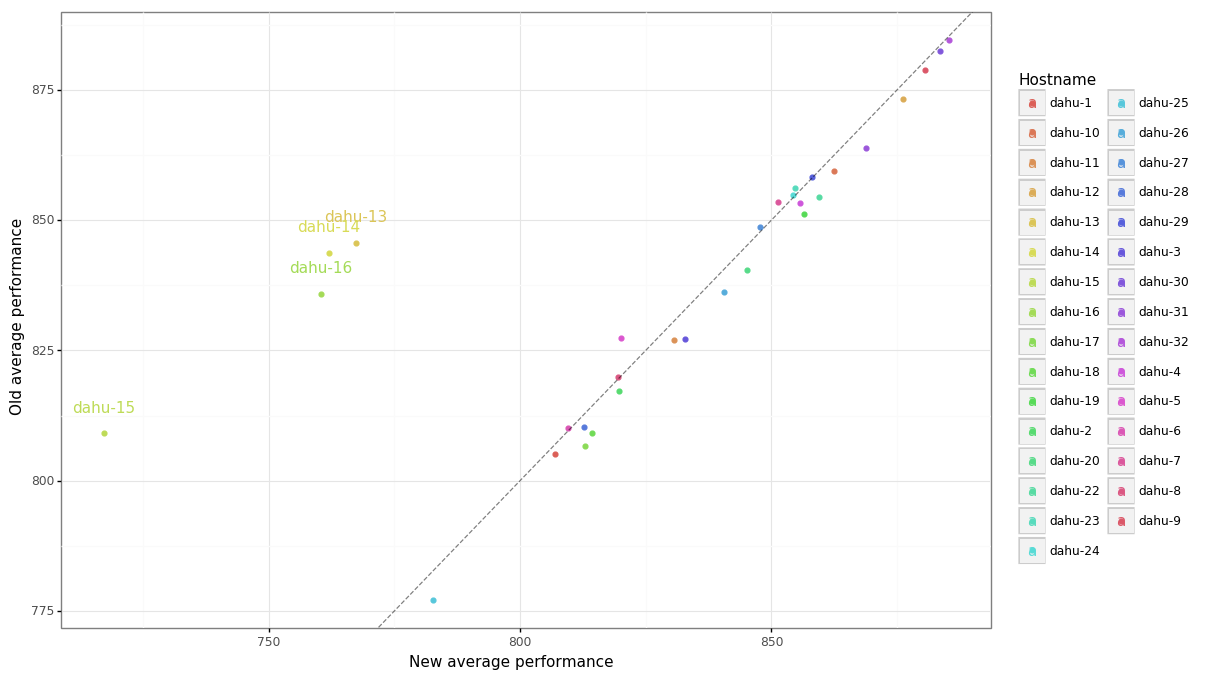

<ggplot: (-9223363310503096355)>

In [11]:
plot = ggplot(grouped, aes(x='mean_new', y='mean_old', color='factor(hostname)', label='hostname')) + geom_point() + theme_bw()
tmp = grouped[grouped.hostname.isin(problematic_hosts)].copy()
tmp['mean_old'] += 5
plot + geom_text(tmp) + xlab('New average performance') + ylab('Old average performance') + geom_abline(intercept=0, slope=1, linetype='dashed', alpha=0.5) + labs(color='Hostname')

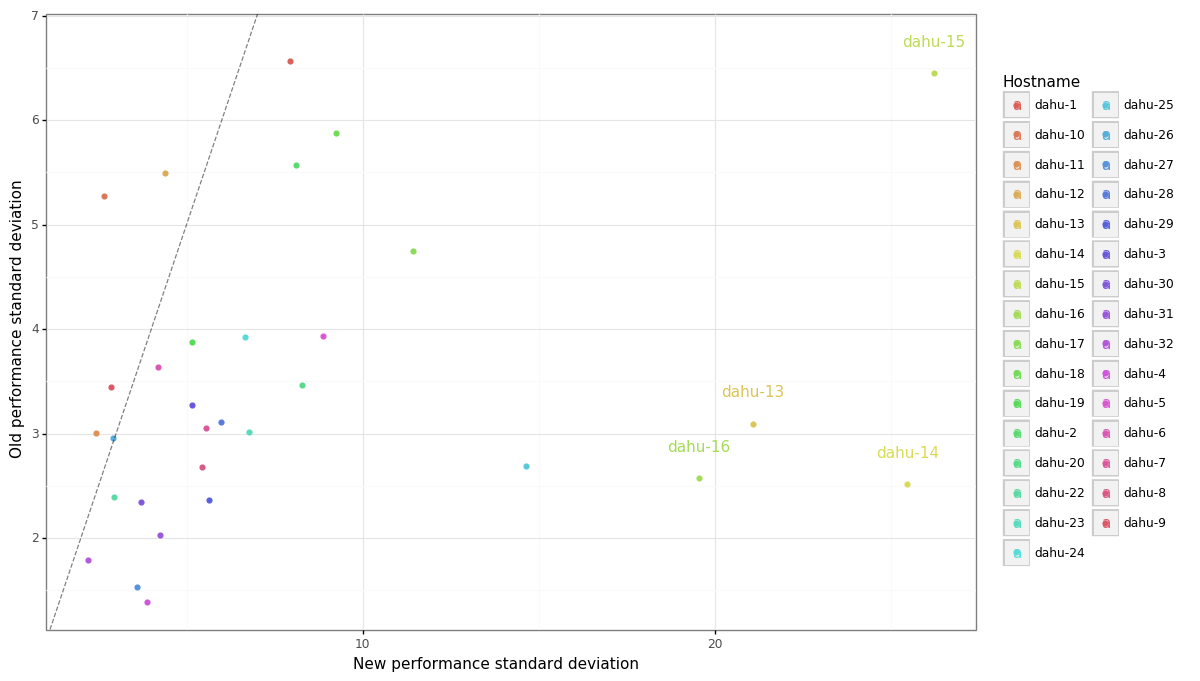

<ggplot: (-9223363310503197987)>

In [12]:
plot = ggplot(grouped, aes(x='std_new', y='std_old', color='factor(hostname)', label='hostname')) + geom_point() + theme_bw()
tmp = grouped[grouped.hostname.isin([('dahu-%d' % i) for i in range(13, 17)])].copy()
tmp['std_old'] += 0.3
plot + geom_text(tmp) + xlab('New performance standard deviation') + ylab('Old performance standard deviation') + geom_abline(intercept=0, slope=1, linetype='dashed', alpha=0.5) + labs(color='Hostname')